### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [1]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2022-11-17 10:51:42--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 165.112.9.230, 2607:f220:41f:250::229, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  1.05MB/s    in 1.1s    

2022-11-17 10:51:44 (1.05 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2022-11-17 10:51:44--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.229, 165.112.9.230, 2607:f220:41f:250::228, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.

### Reading sequences

In [2]:
!pip install bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 272 kB 4.2 MB/s 
     |████████████████████████████████| 2.6 MB 60.9 MB/s 


In [3]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [4]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [6]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'), 
      seq.count('A'), seq.count('G')
    ]) / len(seq)


def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)


def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T, 
                       index=['T', 'C', 'A', 'G'], 
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [7]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181203,0.296080,0.314970,0.272901
C,0.206748,0.226955,0.233379,0.228714
A,0.256854,0.302191,0.238267,0.276767
G,0.355196,0.174773,0.213384,0.221619


### Transition probabilities

In [8]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3], 
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1
        
    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5), 
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [9]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185541,0.498016,0.316087,0.318294
C|T,0.189713,0.199146,0.180139,0.208396
A|T,0.249076,0.172641,0.221208,0.244180
G|T,0.375670,0.130197,0.282566,0.229130
T|C,0.185250,0.248514,0.269667,0.252617
C|C,0.156196,0.198164,0.244435,0.213797
A|C,0.276236,0.315008,0.244359,0.286844
G|C,0.382318,0.238314,0.241540,0.246742
T|A,0.180048,0.334056,0.307936,0.269508
C|A,0.194071,0.213889,0.193709,0.205264


TATTACTTC

In [10]:
P_seq_nc = t1['nc']['T']   * t2['nc']['A|T'] * t2['nc']['T|A'] * \
           t2['nc']['T|T'] * t2['nc']['A|T'] * t2['nc']['C|A'] * \
           t2['nc']['T|C'] * t2['nc']['T|T'] * t2['nc']['C|T']
P_seq_nc

4.800850646089566e-06

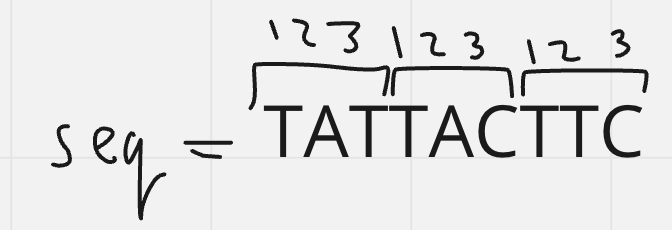

In [11]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.933667623206424e-07

In [12]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8285589420792552

In [13]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.1714410579207448

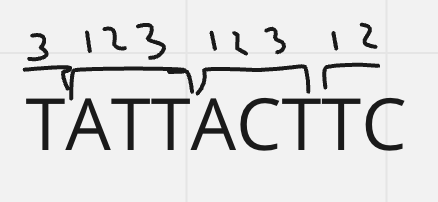

In [14]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.397316710439334e-06

### Prediction

In [16]:
def cod_proba(seq, t1, t2):
    frames = [1, 2, 3, 'nc']
    p_seq = {
             1 : t1['pos1'][seq[0]],
             2 : t1['pos2'][seq[0]],
             3 : t1['pos3'][seq[0]],
             'nc' : t1['nc'][seq[0]]
             }
    p_seq_pos = {1 : 1, 2 : 2, 3 : 3}

    for frame in frames:
        if frame != 'nc':
            for i in range(1, len(seq)):
                if p_seq_pos[frame] == 3:
                    p_seq_pos[frame] = 1
                else:
                    p_seq_pos[frame] += 1
                p_seq[frame] *= t2[f'pos{p_seq_pos[frame]}'][f'{seq[i]}|{seq[i-1]}']

        elif frame == 'nc':
            for i in range(1, len(seq)):
                p_seq[frame] *= t2['nc'][f'{seq[i]}|{seq[i-1]}']
    
    p = {}
    for frame in frames:
        p[frame] = p_seq[frame]/(sum(p_seq.values()))

    return p

In [17]:
cod_proba("TATTACTTC", t1, t2)

{1: 0.07121576910973004,
 2: 0.2693555208286208,
 3: 0.3152494158566611,
 'nc': 0.34417929420498805}

In [19]:
def cod_proba96(seq, t1, t2):
    probas = []
    for i in range(0, len(seq)-95, 12):
        probas.append(cod_proba(seq[i:i+96], t1, t2))
    return probas

In [20]:
probs = cod_proba96(seq[0:3000], t1, t2)

In [21]:
probs[0]

{1: 0.835964366961854,
 2: 2.7418072301105945e-06,
 3: 0.017567431350284518,
 'nc': 0.14646545988063125}

In [22]:
to_list = lambda x: [np.array(list(i.values())) for i in x]

In [23]:
probs_list = np.array(to_list(probs))

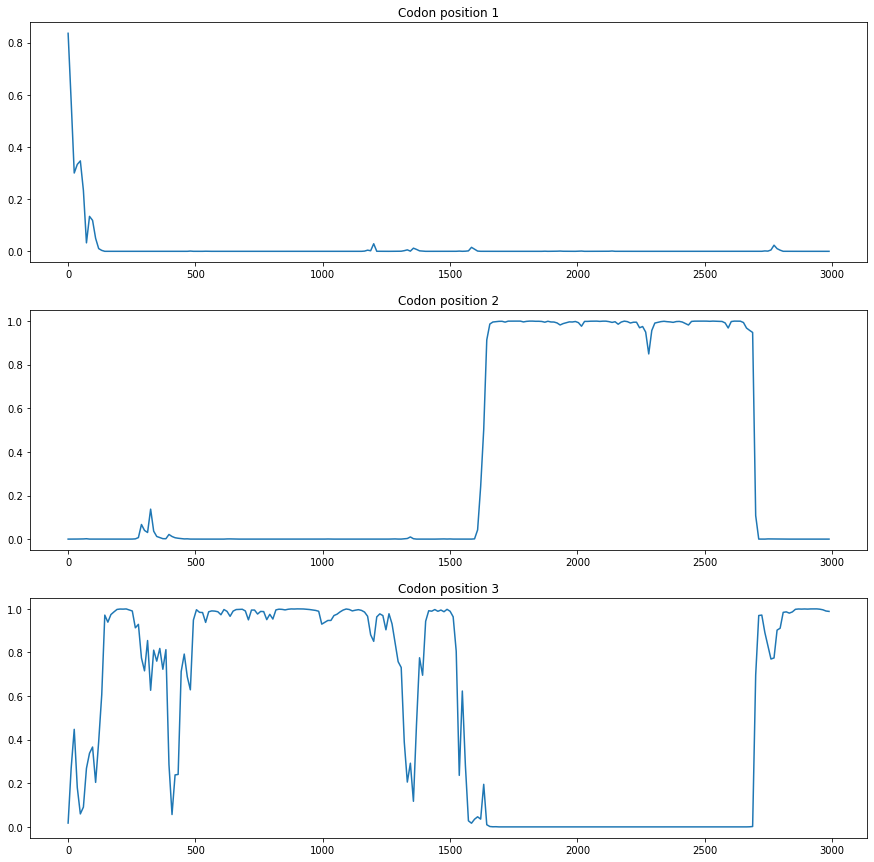

In [27]:
def plot_graph(data, start, end, step):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

  x = range(start, end, step)

  ax1.plot(x, data[:, 0])
  ax2.plot(x, data[:, 1])
  ax3.plot(x, data[:, 2])

  ax1.set_title('Codon position 1')
  ax2.set_title('Codon position 2')
  ax3.set_title('Codon position 3')

  plt.plot()


start = 0
end = 3000
step = 12
window = 96

probs_list_plot= np.array(to_list(cod_proba96(seq[start:end+window-1], t1, t2)))

plot_graph(probs_list_plot, start, end, step)
plt.savefig(fname = 'grath.jpg')